In [2]:
from sklearn.tree import DecisionTreeClassifier, export_text
import numpy as np

In [3]:
# Define plans
plans = [
    {
        "name": "Basic Plan",
        "data": "5GB",
        "price": 20,
        "needs": "Low",
        "tag": ["Individual"],
        "extras": [],
        "discount_eligible": []
    },
    {
        "name": "Moderate Plan",
        "data": "15GB",
        "price": 30,
        "needs": "Moderate",
        "tag": ["Individual"],
        "extras": ["Data rollover", "Streaming app (6 months)"],
        "discount_eligible": []
    },
    {
        "name": "Student Plan",
        "data": "40GB",
        "price": 40,
        "needs": "Moderate",
        "tag": ["Student"],
        "extras": ["Gaming app subscription"],
        "discount_eligible": ["Students"]
    },
    {
        "name": "Unlimited Standard",
        "data": "Unlimited Std",
        "price": 60,
        "needs": "Unlimited",
        "tag": ["Individual", "Student"],
        "extras": ["Gaming app subscription"],
        "discount_eligible": ["Students", "Veterans", "First Responders"]
    },
    {
        "name": "Unlimited Premium",
        "data": "Unlimited Prt",
        "price": 80,
        "needs": "Unlimited",
        "tag": ["Business", "International", "Family"],
        "extras": ["Netflix", "Spotify", "Intl calls"],
        "discount_eligible": ["Students", "Seniors", "First Responders", "Veterans"]
    }
]

In [4]:
# Function to normalize data
def normalize_data(data):
    if isinstance(data, str):
        if "Unlimited Std" in data:
            return 100
        elif "Unlimited Prt" in data:
            return 100
        else:
            return int(data.replace("GB", "").strip())
    return data

In [5]:
# Function to calculate discounted prices for all categories
def calculate_discounted_prices(plan):
    discounts = {
        "Students": 0.20,  # 20% discount
        "Seniors": 10,     # $10 discount
        "First Responders": 0.30,  # 30% discount
        "Veterans": 0.30   # 30% discount
    }

    # Calculate discounted prices for each eligible user type
    discounted_prices = {}
    for category, discount in discounts.items():
        if category in plan["discount_eligible"]:
            if isinstance(discount, float):
                discount_amount = plan["price"] * discount
            else:
                discount_amount = discount
            discounted_prices[category] = max(plan["price"] - discount_amount, 0)
        else:
            discounted_prices[category] = plan["price"]
    return discounted_prices

# Function to calculate the score for a given plan based on user query
def calculate_score(plan, user_query):
    # Define scoring weights for each criterion
    data_match_weight = 5
    budget_match_weight = 3
    user_type_match_weight = 2
    extras_match_weight = 1

    score = 0

    # Match data needs
    user_data = normalize_data(user_query["data_needs"])
    plan_data = normalize_data(plan["data"])
    if plan_data >= user_data:
        score += data_match_weight

    # Match budget
    discounted_price = calculate_discounted_prices(plan).get(user_query["user_type"], plan["price"])
    if user_query["budget"] >= discounted_price:
        score += budget_match_weight

    # Match user type (tags)
    if user_query["user_type"] in plan["tag"]:
        score += user_type_match_weight

    # Match extras
    if "preferred_extras" in user_query:
        for extra in user_query["preferred_extras"]:
            if extra in plan["extras"]:
                score += extras_match_weight

    return score

# Function to recommend plans based on the user query
def recommend_plans(user_query, plans, max_recommendations=2):
    recommendations = []

    # Calculate scores for all plans
    for plan in plans:
        score = calculate_score(plan, user_query)
        if score > 0:
            discounted_prices = calculate_discounted_prices(plan)  # Get all discounted prices
            user_discounted_price = discounted_prices.get(user_query["user_type"], plan["price"])
            recommendations.append((plan, score, user_discounted_price, discounted_prices))

    # Sort recommendations by score in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Get the top recommendations (up to max_recommendations)
    top_recommendations = recommendations[:max_recommendations]

    # If no plans meet the criteria
    if not top_recommendations:
        return "No suitable plans found."

    # Format results
    result = []
    for plan, score, user_discounted_price, discounted_prices in top_recommendations:
        result.append({
            "name": plan["name"],
            "price": plan["price"],
            "user_discounted_price": user_discounted_price,
            "data": plan["data"],
            "tag": plan["tag"],
            "extras": plan["extras"],
            "discount_eligible": plan["discount_eligible"],
            "discounted_prices": discounted_prices,
            "score": score
        })
    return result

# Example user query
user_query = {
    "budget": 20,
    "data_needs": "10GB",
    "user_type": "Individual",
    "preferred_extras": []
}

# Get recommendations
recommended_plans = recommend_plans(user_query, plans, max_recommendations=2)

# Display recommendations
if recommended_plans != "No suitable plans found.":
    print("Recommended Plans:")
    for plan in recommended_plans:
        print(f"Plan Name: {plan['name']}")
        print(f"Price: ${plan['price']}")
        print(f"User Discounted Price: ${plan['user_discounted_price']:.2f}")
        print("Discounted Prices for All Categories:")
        for category, discounted_price in plan["discounted_prices"].items():
            print(f"  {category}: ${discounted_price:.2f}")
        print(f"Data: {plan['data']}")
        print(f"User Type: {', '.join(plan['tag'])}")
        print(f"Extras: {', '.join(plan['extras'])}")
        print(f"Discount Eligible: {', '.join(plan['discount_eligible'])}")
        print(f"Score: {plan['score']}")
        print("-" * 40)
else:
    print(recommended_plans)


Recommended Plans:
Plan Name: Moderate Plan
Price: $30
User Discounted Price: $30.00
Discounted Prices for All Categories:
  Students: $30.00
  Seniors: $30.00
  First Responders: $30.00
  Veterans: $30.00
Data: 15GB
User Type: Individual
Extras: Data rollover, Streaming app (6 months)
Discount Eligible: 
Score: 7
----------------------------------------
Plan Name: Unlimited Standard
Price: $60
User Discounted Price: $60.00
Discounted Prices for All Categories:
  Students: $48.00
  Seniors: $60.00
  First Responders: $42.00
  Veterans: $42.00
Data: Unlimited Std
User Type: Individual, Student
Extras: Gaming app subscription
Discount Eligible: Students, Veterans, First Responders
Score: 7
----------------------------------------


In [6]:
# Features: [is_existing_customer, is_unlimited_plan, tenure_years]
# Rewards: 0 = No reward, 1 = Loyalty Points, 2 = Free Phone, 3 = Accessory Discount, 4 = Cashback
X = [
    [1, 1, 5],
    [1, 0, 2],
    [0, 1, 0],
    [0, 0, 0],
    [1, 1, 10],
    [0, 1, 0],
]

y = [
    1,  # Loyalty Points
    3,  # Accessory Discount
    2,  # Free Phone
    0,  # No reward
    4,  # Cashback
    2,  # Free Phone
]

In [11]:
# Train the decision tree
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Function to get reward
def get_reward(customer_status, plan_type, tenure_years):
    is_existing_customer = 1 if customer_status["is_existing_customer"] else 0
    is_unlimited_plan = 1 if "Unlimited" in plan_type else 0
    input_features = np.array([is_existing_customer, is_unlimited_plan, tenure_years]).reshape(1, -1)
    
    # Predict reward
    reward_num = clf.predict(input_features)[0]
    reward_map = {
        0: "No Reward",
        1: "Loyalty Points",
        2: "Free Phone",
        3: "Accessory Discount",
        4: "Cashback"
    }
    reward_description = reward_map[reward_num]  # Map numerical reward to description
    
    return reward_num, reward_description

# Example usage
customer_status = {"is_existing_customer": True}
plan_type = "Unlimited Prt"
tenure_years = 5

reward = get_reward(customer_status, plan_type, tenure_years)
print(f"Reward: {reward}")

# Visualize the decision tree
print(export_text(clf, feature_names=["is_existing_customer", "is_unlimited_plan", "tenure_years"]))


Reward: (np.int64(1), 'Loyalty Points')
|--- is_existing_customer <= 0.50
|   |--- is_unlimited_plan <= 0.50
|   |   |--- class: 0
|   |--- is_unlimited_plan >  0.50
|   |   |--- class: 2
|--- is_existing_customer >  0.50
|   |--- tenure_years <= 3.50
|   |   |--- class: 3
|   |--- tenure_years >  3.50
|   |   |--- tenure_years <= 7.50
|   |   |   |--- class: 1
|   |   |--- tenure_years >  7.50
|   |   |   |--- class: 4



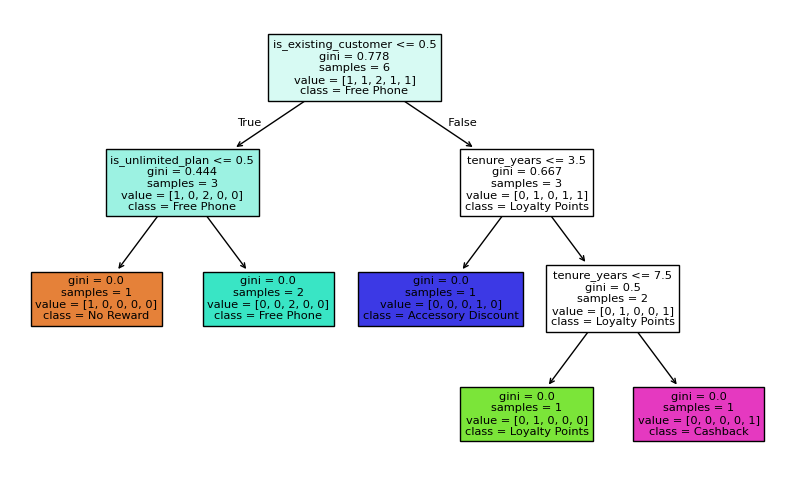

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_tree(clf, feature_names=["is_existing_customer", "is_unlimited_plan", "tenure_years"], class_names=["No Reward", "Loyalty Points", "Free Phone", "Accessory Discount", "Cashback"], filled=True)
plt.show()

In [17]:
customer_status = {"is_existing_customer": False}
plan_type = "Unlimited Prt"
tenure_years = 0
reward_num, reward_description = get_reward(customer_status, plan_type, tenure_years)
print(f"Predicted Reward (Code): {reward_num}")
print(f"Predicted Reward (Description): {reward_description}")

Predicted Reward (Code): 2
Predicted Reward (Description): Free Phone
